In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import tensorflow as tf
from Bio import SeqIO
from tqdm.notebook import tqdm

In [2]:
project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
data_dir = os.path.join(project_dir, "data", "deepmicrobes_mock_communities")
models_dir = os.path.join(project_dir, "models")

## Analysis

In [32]:
read_lens = defaultdict(int)
for filename in [filename for filename in os.listdir(data_dir) if filename.endswith(".1.fq")]:
    with open(os.path.join(data_dir, filename), "rt") as file:
        reads = SeqIO.parse(file, "fastq")
        for read in tqdm(reads, total=10000000, desc=f"Parsing file \"{filename}\""):
            read_lens[len(read)] += 1

Parsing file "mock_metagenome_01.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_02.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_03.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_04.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_05.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_06.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_07.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_08.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_09.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

Parsing file "mock_metagenome_10.1.fq":   0%|          | 0/10000000 [00:00<?, ?it/s]

No. of reads: 100,000,000
% of reads with length < 100 nt: 3.49


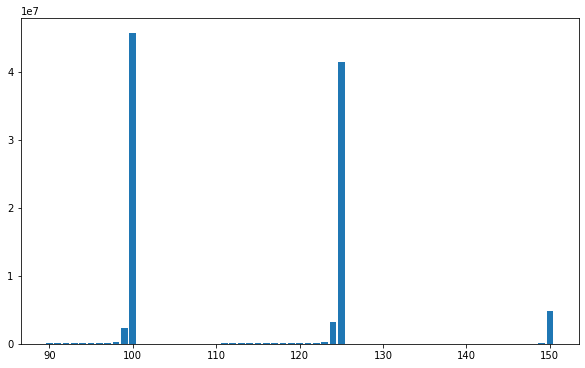

In [43]:
lens = []
counts = []
for l, c in sorted(read_lens.items()):
    lens.append(l)
    counts.append(c)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(lens, counts)
print(f"No. of reads: {sum(counts):,}")
print(f"% of reads with length < 100 nt: {sum([c for l, c in read_lens.items() if l < 100]) / sum(counts) * 100:.2f}")

In [3]:
autoencoder_name = "661k_conv_small_loc_pres_ld10_ws100"
encoder = tf.keras.models.load_model(os.path.join(models_dir, "autoencoders", autoencoder_name)).encoder
window_size = 100
batch_size = 5000

In [11]:
nuc_onehot_enc = {
    "A": [1, 0, 0, 0],
    "G": [0, 1, 0, 0],
    "C": [0, 0, 1, 0],
    "T": [0, 0, 0, 1],
    "N": [0, 0, 0, 0]}
embeddings = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
embeddings_write_ind = 0
for filename in [filename for filename in os.listdir(data_dir)[:1] if filename.endswith(".1.fq")]:
    with open(os.path.join(data_dir, filename), "rt") as file:
        reads = SeqIO.parse(file, "fastq")
        batch = tf.TensorArray(dtype=tf.float32, size=batch_size, element_shape=[window_size, 4])
        batch_write_ind = 0
        for read in tqdm(reads, total=10000000):
            if not len(read) < window_size:
                oh_encoded = [nuc_onehot_enc[nuc] for nuc in read.seq[:window_size]]
                batch = batch.write(batch_write_ind, oh_encoded)
                batch_write_ind += 1
                # batch.append(oh_encoded)
                if batch_write_ind == batch_size:
                    embeddings = embeddings.write(embeddings_write_ind, encoder(batch.stack()))
                    embeddings_write_ind += 1
                    batch_write_ind = 0

  0%|          | 0/10000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
embeddings.concat()

<tf.Tensor: shape=(795000, 10), dtype=float32, numpy=
array([[0.        , 0.06378289, 0.3119701 , ..., 0.01076631, 0.        ,
        0.19847557],
       [0.        , 0.17358832, 0.39882246, ..., 0.2119136 , 0.        ,
        0.08448626],
       [0.        , 0.2027297 , 0.25197408, ..., 0.        , 0.        ,
        0.15723798],
       ...,
       [0.        , 0.15934551, 0.32513046, ..., 0.16035081, 0.        ,
        0.23946063],
       [0.        , 0.27236262, 0.35493773, ..., 0.25783747, 0.14639239,
        0.        ],
       [0.        , 0.28724357, 0.12654048, ..., 0.21196744, 0.13475564,
        0.12631735]], dtype=float32)>

## Organism presence prediction

## Abundance estimation